1. Feature Extraction:
* Convert the song to a spectrogram.
* Identify local peaks in the spectrogram to create a “constellation map”.
* Form pairs of peaks within a specified time and frequency distance and record them.


2. Database Construction:
* Store features in the format (f1, f2, t1, t2 - t1, songid) for each song.
* Discard amplitude information to ensure robustness to gain changes across frequency.


3. Clip Identification:
* Extract features from the clip in the same manner.
* Match these features against the database to identify the song.

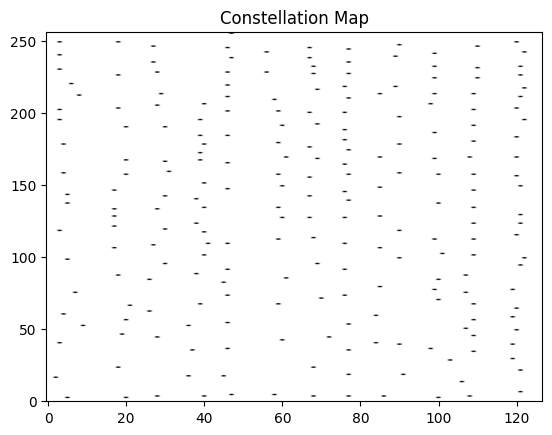

[(2, 75, 5, 2), (2, 66, 20, 1), (2, 28, 100, 3), (2, 102, 100, 1), (3, 95, 28, 2), (3, 71, 68, 2), (3, 95, 68, 1), (3, 34, 108, 1), (3, 45, 108, 1), (3, 56, 108, 1), (4, 42, 58, 2), (4, 67, 58, 1), (4, 85, 58, 3), (6, 99, 121, 1), (13, 34, 106, 3), (13, 45, 106, 3), (13, 50, 106, 1), (16, 40, 2, 1), (16, 60, 2, 2), (16, 98, 2, 3), (17, 35, 36, 1), (17, 67, 36, 3), (17, 88, 36, 2), (17, 36, 45, 1), (17, 54, 45, 1), (17, 73, 45, 1), (21, 99, 121, 1), (23, 46, 18, 1), (23, 56, 18, 2), (23, 66, 18, 3), (23, 71, 68, 2), (23, 95, 68, 1), (29, 49, 119, 1), (29, 64, 119, 1), (29, 94, 119, 2), (35, 67, 37, 2), (35, 88, 37, 1), (35, 101, 37, 3), (36, 70, 98, 2), (36, 77, 98, 1), (36, 84, 98, 2), (39, 49, 119, 1), (39, 64, 119, 1), (39, 94, 119, 2), (40, 60, 3, 1), (40, 98, 3, 2), (40, 137, 3, 2), (40, 79, 84, 1), (40, 106, 84, 1), (40, 128, 84, 1), (42, 85, 60, 1), (44, 95, 28, 2), (44, 119, 28, 2), (44, 142, 28, 2), (46, 56, 19, 1), (46, 66, 19, 2), (49, 94, 120, 1), (49, 99, 120, 2), (49, 123,

In [27]:
import numpy as np
import scipy.io.wavfile as wav
from scipy.signal import resample, spectrogram, butter, lfilter, freqz
import matplotlib.pyplot as plt

# Preprocess Audio
def preprocess_audio(audio_file):
    fs, y = wav.read(audio_file)
    if len(y.shape) == 2:  # Stereo to Mono
        y = np.mean(y, axis=1)
    y = y - np.mean(y)  # Subtract mean
    new_fs = 8000
    y = resample(y, int(len(y) * new_fs / fs))
    return new_fs, y

# Compute Spectrogram
def compute_spectrogram(y, fs):
    window_length = int(0.064 * fs)
    overlap = int(0.032 * fs)
    f, t, Sxx = spectrogram(y, fs, nperseg=window_length, noverlap=overlap)
    return f, t, np.log(np.abs(Sxx) + 1e-10)  # Log magnitude spectrogram

# Identify Local Peaks
def find_local_peaks(S, gs=9):
    P = np.ones_like(S, dtype=bool)
    for i in range(-gs//2, gs//2 + 1):
        for j in range(-gs//2, gs//2 + 1):
            if i == 0 and j == 0:
                continue
            shifted = np.roll(S, (i, j), axis=(0, 1))
            P &= S > shifted
    return P

def plot_constellation_map(P):
    plt.imshow(P, aspect='auto', origin='lower', cmap='gray_r')
    plt.title('Constellation Map')
    plt.show()

# Threshold Peaks
# Threshold Peaks
def threshold_peaks(P, rate, fs, duration):
    num_peaks = int(rate * len(P))  # Calculate the number of peaks based on the rate
    sorted_peaks = np.sort(P.flatten())[::-1]
    threshold = sorted_peaks[num_peaks]
    return P > threshold

# Inside make_table function



# Construct Peak Pairs Table
def construct_peak_pairs(P, dt_l=0, dt_u=3, df=100, fanout=3):
    pairs = []
    peak_indices = np.argwhere(P)
    for i, (f1, t1) in enumerate(peak_indices):
        count = 0
        for j, (f2, t2) in enumerate(peak_indices[i+1:]):
            if dt_l < t2 - t1 <= dt_u and abs(f2 - f1) <= df:
                pairs.append((f1, f2, t1, t2 - t1))
                count += 1
                if count >= fanout:
                    break
    return pairs

# Combine Everything into a Function
def make_table(audio_file):
    fs, y = preprocess_audio(audio_file)
    f, t, S = compute_spectrogram(y, fs)
    P = find_local_peaks(S)
    P = threshold_peaks(P, 50, fs, len(y)/fs)
    plot_constellation_map(P)
    pairs = construct_peak_pairs(P)
    return pairs

# Example usage
audio_file = 'taunt.wav'  # Replace with your .wav file path
pairs = make_table(audio_file)
print(pairs)


Summary of Important Points
The objective is to develop a Shazam-like music identification system.
The system involves creating a database of song features and matching clip features to identify the song.
Key steps include preprocessing the audio, computing the spectrogram, identifying local peaks, thresholding to select significant peaks, and constructing peak pairs.
Python can be used to implement the various steps for audio preprocessing, spectrogram computation, peak identification, and feature extraction.

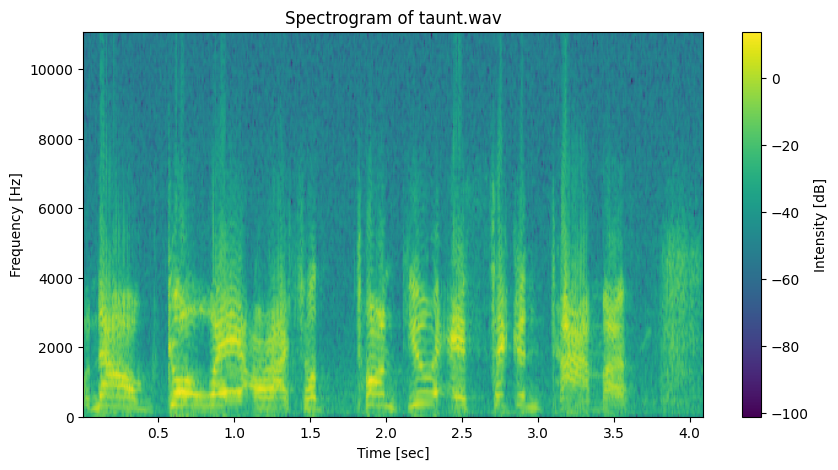

: 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram

def spectrogram_signal():
    # Read the wav file
    fs, data = wavfile.read('taunt.wav')
    
    # Compute the spectrogram
    f, t, Sxx = spectrogram(data, fs, nperseg=205)
    
    # Plot the spectrogram
    plt.figure(figsize=(10, 5))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='Intensity [dB]')
    plt.title('Spectrogram of taunt.wav')
    plt.show()

# Call the function to display the spectrogram
spectrogram_signal()


In [2]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [28]:
pip install pydub
